In [1]:
import pims
from matplotlib import pyplot as plt
from matplotlib import cm
import numpy as np
import time
from scipy.stats import skew
from scipy.sparse.linalg import eigsh
from FaceMap import utils, facemap

filenames = ['D:/cams5/mouse_face.mp4']

video = pims.Video(filenames[0])
Ly = video.frame_shape[0]
Lx = video.frame_shape[1]
# number of frames in the movie
nframes = len(video)

In [5]:
# get subsampled mean across frames
# grab up to 2000 frames to average over for mean

nf = min(2000, nframes)

# load in chunks of up to 200 frames (for speed)
nt0 = min(200, nframes)
nsegs = int(np.floor(nf / nt0))

# what times to sample
tf = np.floor(np.linspace(0, nframes - nt0, nsegs)).astype(int)

avgframe = np.zeros((Ly, Lx), np.float32)
avgmotion = np.zeros((Ly, Lx), np.float32)

ns = 0
for n in range(nsegs):
    t = tf[n]
    
    im = np.array(video[t:t+nt0])
    # im is TIME x Ly x Lx x 3 (3 is RGB)
    if im.ndim > 3:
        im = im[:,:,:,0]
    # convert im to Ly x Lx x TIME
    im = np.transpose(im, (1,2,0)).astype(np.float32)
    
    # most movies have integer values
    # convert to float to average
    im = im.astype(np.float32)
    
    # add to averages
    avgframe += im.mean(axis=-1)
    immotion = np.abs(np.diff(im, axis=-1))
    avgmotion += immotion.mean(axis=-1)
    ns+=1

avgframe /= float(ns)
avgmotion /= float(ns)

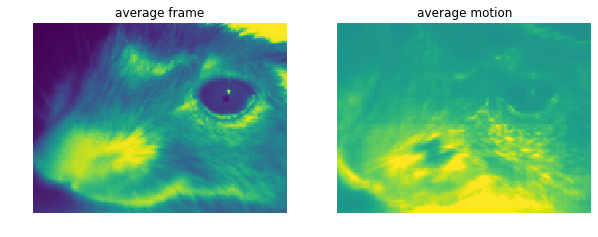

In [6]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(avgframe)
plt.title('average frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(avgmotion, vmin=-10, vmax=10)
plt.title('average motion')
plt.axis('off')
plt.show()

In [9]:
# compute incremental SVD across frames
# load chunks of 1000 and take 250 PCs from each
# then concatenate and take SVD of compilation of 250 PC chunks
# number of components kept from SVD is ncomps
ncomps = 500

nt0 = min(1000, nframes) # chunk size
nsegs = int(min(np.floor(25000 / nt0), np.floor(nframes / nt0)))
nc = 250 # <- how many PCs to keep in each chunk

# what times to sample
tf = np.floor(np.linspace(0, nframes-nt0-1, nsegs)).astype(int)

# giant U that we will fill up with smaller SVDs
U = np.zeros((Ly*Lx, nsegs*nc), np.float32)

for n in range(nsegs):
    t = tf[n]
    im = np.array(video[t:t+nt0])
    # im is TIME x Ly x Lx x 3 (3 is RGB)
    if im.ndim > 3:
        im = im[:,:,:,0]
    # convert im to Ly x Lx x TIME
    im = np.transpose(im, (1,2,0)).astype(np.float32)
    
    # most movies have integer values
    # convert to float to average
    im = im.astype(np.float32)

    im = np.abs(np.diff(im, axis=-1))
    im = np.reshape(im, (Ly*Lx, -1))

    # subtract off average motion
    im -= avgmotion.flatten()[:,np.newaxis]
    
    # take SVD
    usv  = utils.svdecon(im, k=nc)
    
    U[:, n*nc:(n+1)*nc] = usv[0]

# take SVD of concatenated spatial PCs
### USV = ???
USV = utils.svdecon(U, k=ncomps)
U = USV[0]

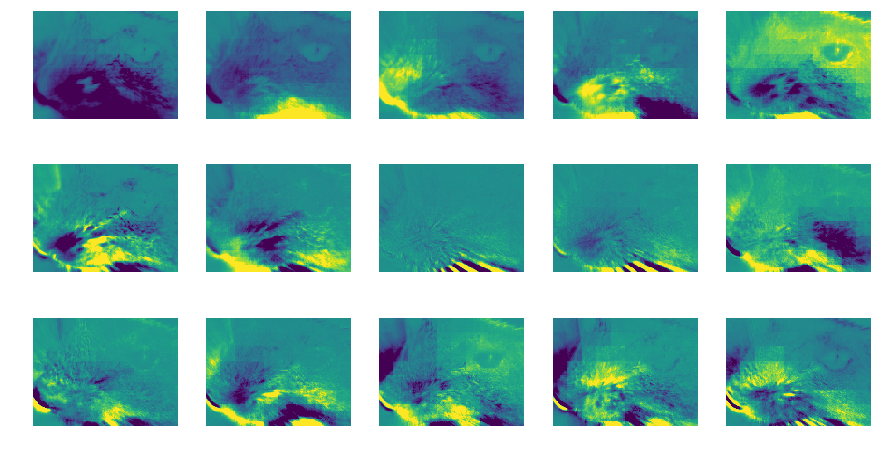

In [10]:
motMask = np.reshape(U, (Ly, Lx, ncomps))
plt.figure(figsize=(15,8))
for i in range(15):
    ax=plt.subplot(3,5,i+1)
    ax.imshow(motMask[:,:,i] / motMask[:,:,i].std(), vmin=-2, vmax=2)
    ax.axis('off')
plt.show()

In [16]:
### when do these spatial PCs occur in time?
# project spatial PCs onto movies (in chunks again)

ncomps = U.shape[1]
nt0 = min(1000, nframes) # chunk size
nsegs = int(np.ceil(nframes / nt0))

# time ranges
itimes = np.floor(np.linspace(0, nframes, nsegs+1)).astype(int)

# projection of spatial PCs onto movie
motSVD = np.zeros((nframes, ncomps), np.float32)

for n in range(nsegs):
    im = np.array(video[itimes[n]:itimes[n+1]])
    # im is TIME x Ly x Lx x 3 (3 is RGB)
    if im.ndim > 3:
        im = im[:,:,:,0]
    # convert im to Ly x Lx x TIME
    im = np.transpose(im, (1,2,0)).astype(np.float32)

    im = np.reshape(im, (Ly*Lx, -1))
    
    # we need to keep around the last frame for the next chunk
    if n>0:
        im = np.concatenate((imend[:, np.newaxis], im), axis=-1)
    imend = im[:,-1]        
    im = np.abs(np.diff(im, axis=-1))

    # subtract off average motion
    im -= avgmotion.flatten()[:,np.newaxis]
    
    # project U onto immotion
    vproj = im.T @ U
    if n==0:
        vproj = np.concatenate((vproj[0,:][np.newaxis, :], vproj), axis=0)

    motSVD[itimes[n]:itimes[n+1], :] = vproj


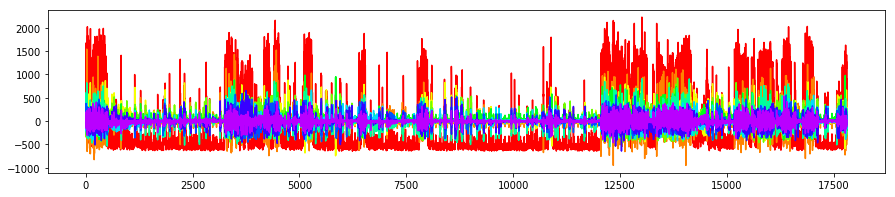

In [18]:
plt.figure(figsize=(15,3))
# flip traces
motSVD *= np.sign(skew(motSVD, axis=0))[np.newaxis,:]
cmap = cm.get_cmap('hsv')
cmap = cmap(np.linspace(0,.8,10))
for n in range(10):
    plt.plot(motSVD[:,n], color=cmap[n,:])
plt.show()

In [119]:
# let's take this 500-dimensional representation and reduce it with Rastermap
from rastermap import Rastermap

model = Rastermap(n_components=2, n_X=15, alpha=1)
y = model.fit_transform(motSVD)


time; iteration;  explained PC variance
0.21s     0        0.4828
2.40s    10        0.6625
4.78s    20        0.6884
7.20s    30        0.6920
8.91s   final      0.6917
9.17s upsampled    0.8084


<IPython.core.display.Javascript object>


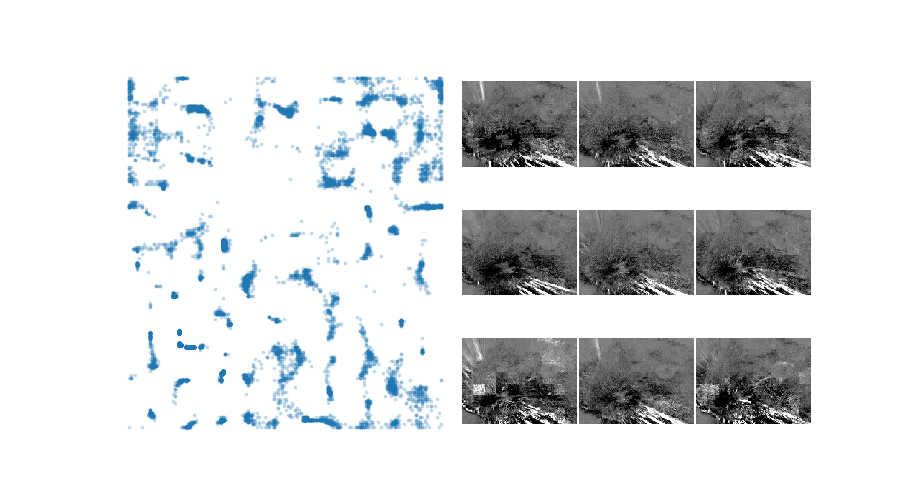

In [123]:
from importlib import reload
reload(plt)
%matplotlib notebook

# create figure and plot scatter

# create the annotations box
#im = OffsetImage(img0[0,:,:])
fig, axes = plt.subplots(3,6, figsize=(9,5))
fig.subplots_adjust(hspace=0.01, wspace=0.02)
for ni in range(3):
    for nj in range(6):
        axes[ni,nj].axis('off')

cmap = cm.get_cmap('hsv')
cmap = cmap(np.linspace(0,.85,y.shape[0]))
ax = fig.add_subplot(1,2,1)
ax.scatter(y[:,0],y[:,1], s=3, alpha=.2)
ax.axis('off')
    
def onclick(event):
    # if the mouse is over the scatter points
    #if line.contains(event)[0]:
    # find out the index within the array from the event
    dists = (y[:,0]-event.xdata)**2 + (y[:,1]-event.ydata)**2
    inds = dists.argsort()[:12]
    face = motSVD[inds,:] @ U.T
    face /= face.std(axis=1)[:,np.newaxis]
    face = np.reshape(face, (-1,Ly,Lx))
            
    for ni in range(3):
        for nj in range(3):
            axes[ni,nj+3].imshow(face[ni+nj*3,:,:],plt.get_cmap('gray'),vmin=-2,vmax=2)
            axes[ni,nj+3].axis('off')
    plt.show()
    #fig.canvas.draw_idle()

# add callback for mouse moves
fig.canvas.mpl_connect('button_press_event', onclick)           
plt.show()
